In [40]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [41]:
def firapm(h, L):
    n = len(h)
    H = np.fft.fft(h, 2 * L)
    H = H[0:L]
    w = np.arange(0, L, 1) * np.pi / L
    m = (n-1)/2
    j = complex(0, 1)
    H = np.multiply(np.exp(m*j*w), H)
    H = np.real(H)
    return H

In [42]:
def ideal_filter(x, bandedge, filttype):
    if filttype == 'High':
        return 1.0 if x > bandedge else 0.0
    elif filttype == 'Low':
        return 1.0 if x < bandedge else 0.0
    else:
        print("filter type is invalid, choose High or Low.")

In [43]:
def coefficient_matrix(x, a, order = 0):
    if order == 0:
        return sum(a*np.cos(x*k) for k,a in enumerate(a))
    elif order == 1:
        return sum(-a*k*np.sin(x*k) for k,a in enumerate(a))
    else:
        return sum(-a*k*k*np.cos(x*k) for k,a in enumerate(a))

In [44]:
def LocExtrema(a,div):        

   
    def f(x):
        return coefficient_matrix(x, a, order=1)

  
    def df(x):
        return coefficient_matrix(x, a, order=2)

   
    def NewtonRaphson(x0):
        x = x0
        for _ in range(100):
            x_next = x - f(x) / df(x)
            if abs(x_next - x) < 1.0e-8:
                break
            x = x_next
        
        return x

    
    check_points = np.linspace(0.0, np.pi, div)

  
    sign_reverse_section = [p for p in zip(check_points, check_points[1:]) if f(p[0])*f(p[1]) <= 0]

 
    return [NewtonRaphson(x) for x,_ in sign_reverse_section]

In [45]:
def initialize(n, bandedge, transition): 

    num_point = n+2


    num_passband = int(num_point*bandedge/np.pi)


    num_stopband = num_point-num_passband

   
    return np.append(
        np.linspace(     0.0, bandedge-0.5*transition, num_passband),
        np.linspace(bandedge+0.5*transition,  np.pi, num_stopband))

In [46]:
def SolveForA(arrx, bandedge, filttype):  

   
    matrix_cosines = np.array(
        [[np.cos(x*k) for k in range(len(arrx)-1)] + [(-1)**j] \
                        for j,x in enumerate(arrx)])

  
    vector_b = np.array([ideal_filter(x, bandedge, filttype) for x in arrx])

 
    u = np.linalg.solve(matrix_cosines, vector_b)

   
    return u[:-1], u[-1]

In [47]:
def CriticalCount(a, bandedge, transition):  

   
    n = len(a)-1

    
    extreme_points = LocExtrema(a, (n+2)*10)

    extreme_points.append(bandedge-transition*0.5)
    extreme_points.append(bandedge+transition*0.5)
    extreme_points.sort()

    if len(extreme_points) == n+1:
      
        extreme_points.append(np.pi)
        return extreme_points

    elif len(extreme_points) == n+2:
       
        return extreme_points

    elif len(extreme_points) == n+3:
     
        extreme_points.pop(0)
        return extreme_points

    else:
        raise Exception("[ERROR]number of extreme point " + \
            str(n+2) + "->" + str(len(extreme_points)))

In [48]:
def check_convergence(a, x, bandedge, filttype):

  
    def ef(x):
        return coefficient_matrix(x, a, order=0)-ideal_filter(x, bandedge, filttype)

    return np.var([ef(x)*(-1)**k for k,x in enumerate(x)]) < 1.0e-12

In [49]:
def PM(order, bandedge, transition, filttype = "Low"):

    n = (order-1)//2 

    max_iter=100
    
    x = initialize(n, bandedge, transition)

    for epoch in range(1, max_iter+1):
        
        list_a, d = SolveForA(x, bandedge, filttype)

       
        x = CriticalCount(list_a, bandedge, transition)

        if check_convergence(list_a, x, bandedge, filttype):
          
            list_h = [a*0.5 for a in reversed(list_a[1:])] + [list_a[0]] + [a*0.5 for a in list_a[1:]]
            return list_h, d, list_a



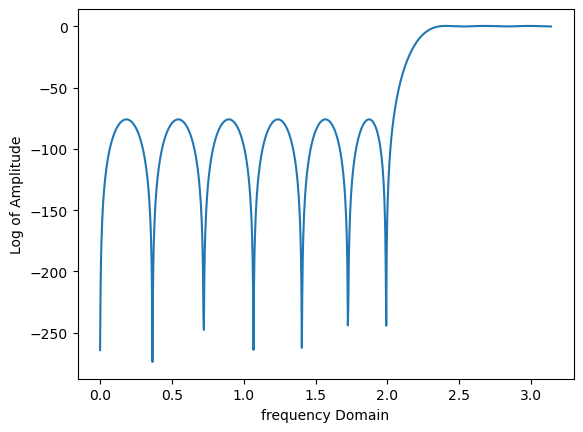

In [54]:
h, d, list_a = PM(order = 40, bandedge = np.pi * 0.7 , transition = np.pi * 0.1 , filttype="High")

a = firapm(h, 1000) 
min = np.min(a)
a = a - 1.0001*min
a = 20 *np.log(a)
plt.xlabel('frequency Domain')
plt.ylabel('Log of Amplitude')
x = np.arange(0, np.pi, np.pi/1000)
plt.plot(x, a)